In [2]:
# from google.colab import drive
# drive.mount('/gdrive')
# !ln -s "/gdrive/My Drive/Colab Notebooks" "/content/Colab Notebooks"

# # Put Colab in the context of the project

# # os.chdir allows you to change directories, like cd in the Terminal
# os.chdir('/content/Colab Notebooks/project-solar-ai-solutions/AerialImageDataset')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [1]:
%cd /content

[Errno 2] No such file or directory: '/content'
/home/abhinav/code/JennyF-slb/solar_ai/notebooks


In [39]:
import os
import glob
import random
# from osgeo import gdal
# import rasterio
import shutil
from types import MethodType

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate,ZeroPadding2D , UpSampling2D,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input


from PIL import Image

In [3]:
# Check if TensorFlow is using GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        print(f"GPU Device Name: {device.name}")
else:
    print("No GPU devices found. Make sure TensorFlow GPU is properly installed.")

# Check TensorFlow version
print("TensorFlow Version:", tf.__version__)

GPU Device Name: /physical_device:GPU:0
GPU Device Name: /physical_device:GPU:1
TensorFlow Version: 2.10.0


In [4]:
os.environ["PYTHONHASHSEED"] = str(23)
np.random.seed(23)
tf.random.set_seed(23)

In [5]:
%pwd
%ll -lsh

total 11M
1.7M -rw-r--r-- 1 abhinav 1.7M May 24 21:08 abhinav_data_pipeline_and_base_model_CNN_24.05.2023.ipynb
2.9M -rw-r--r-- 1 abhinav 2.9M May 23 15:50 abhinav_data_testing_final_23.05.2023.ipynb
776K -rw-r--r-- 1 abhinav 775K May 25 12:05 abhinav_extract_meta_data_25.05.2023.ipynb
8.0K -rw-r--r-- 1 abhinav 5.6K May 22 18:32 abhinav_geotiff_to_png.ipynb
2.8M -rw-r--r-- 1 abhinav 2.8M May 23 14:04 abhinav_initial_data_check_colab.ipynb
 64K -rw-r--r-- 1 abhinav  61K May 22 18:32 abhinav_project_data_downloader.ipynb
108K -rw-r--r-- 1 abhinav 106K May 24 20:52 base_model.png
620K -rw-r--r-- 1 abhinav 617K May 30 00:12 jenny_ming_unet_May29_2023.ipynb
4.0K -rw-r--r-- 1 abhinav   50 May 30 00:12 jenny_ming_unet_May29_2023.ipynb:Zone.Identifier
852K -rw-r--r-- 1 abhinav 850K May 25 11:34 jenny_patching_rasterio_May24_2023.ipynb
144K -rw-r--r-- 1 abhinav 141K May 22 18:26 juani_UNET.ipynb
404K -rw-r--r-- 1 abhinav 404K May 26 13:24 ming_unet.ipynb
4.0K -rw-r--r-- 1 abhinav 1.5K May 26 13

In [8]:
# !mkdir /content/aerialimage

In [9]:
# !ls /content

 aerialimage  'Colab Notebooks'   sample_data


In [6]:
# create a folders to move train and validation files

!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_input
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_target

!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_input
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_target

In [7]:
# create a folders to move train and validation files

!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_input/input_data
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_target/target_data

!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_input/input_data
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_target/target_data

In [8]:
import os
import shutil

# # Specify the path of the file or directory you want to delete!
# directory_paths = ['/content/aerialimage/train_input/input_data',\
#              '/content/aerialimage/train_target/target_data',\
#              '/content/aerialimage/val_input/input_data',\
#              '/content/aerialimage/val_target/target_data']
# # Delete the file
# for dir_path in directory_paths:
#   shutil.rmtree(dir_path)

In [9]:
# move input images to the folder

org_train_input = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train/images'
new_train_input = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_input/input_data'
new_val_input = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_input/input_data'

input_img_paths = []

for dirname, _, filenames in os.walk(org_train_input):
    for filename in filenames:
        input_img_paths.append(os.path.join(dirname, filename))

input_img_paths = sorted(input_img_paths)

random.Random(23).shuffle(input_img_paths)
    
input_img_paths[0:2]


['/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train/images/chicago5.tif',
 '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train/images/kitsap13.tif']

In [10]:
val_num = 40 ## 20% of train dataset 
#select only 10% of available! 
for file in input_img_paths[:val_num:10]:
    shutil.copy(file, new_val_input)
    
for file in input_img_paths[val_num::10]:
    shutil.copy(file, new_train_input)

In [11]:
# move target images to the folder

org_train_target = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train/gt'
new_train_target = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_target/target_data'
new_val_target = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_target/target_data'

target_img_paths = []

for dirname, _, filenames in os.walk(org_train_target):
    for filename in filenames:
        target_img_paths.append(os.path.join(dirname, filename))

target_img_paths = sorted(target_img_paths)

random.Random(23).shuffle(target_img_paths)

target_img_paths[0:2]

['/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train/gt/chicago5.tif',
 '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train/gt/kitsap13.tif']

In [13]:
#copy 40 target images to validation folder
#select only 10% of available! 

for file in target_img_paths[:val_num:10]:
    shutil.copy(file, new_val_target)
    
for file in target_img_paths[val_num::10]:
    shutil.copy(file, new_train_target)

In [14]:
# create an image generator / data augmentation pipeline 
# augment data in train dataset only

BATCH_SIZE = 5
#TARGET_SIZE = (256,256)
TARGET_SIZE = (512,512)
seed = 23
# patch_size = (500, 500)  # Specify the desired patch size
# overlap = 250  # Specify the desired overlap size, 50% for this case

train_datagen = ImageDataGenerator(#rescale=1./255,
                                   samplewise_std_normalization=False, 
                                   horizontal_flip = True, 
                                   vertical_flip = False, # 1st run : False, 2nd run: True
                                   height_shift_range = 0.1, 
                                   width_shift_range = 0.1, 
                                   rotation_range = 3, # 1st run : 3, 2nd run:10
                                   shear_range = 0.01, # 1st run : 0.01, 2nd run: 0.1
                                   fill_mode = 'nearest',
                                   zoom_range = 0.05, #1st run 0.05, 2nd run: 0.1
                                   zca_whitening = True,
                                   zca_epsilon=1e-5, 
#                                    preprocessing_function=patch_image,
                                   )


target_datagen = ImageDataGenerator(rescale=1./255,
                                   samplewise_std_normalization=False, 
                                   horizontal_flip = True, 
                                   vertical_flip = False, # 1st run : False, 2nd run: True
                                   height_shift_range = 0.1, 
                                   width_shift_range = 0.1, 
                                   rotation_range = 3, # 1st run : 3, 2nd run:10
                                   shear_range = 0.01, # 1st run : 0.01, 2nd run: 0.1
                                   fill_mode = 'nearest',
                                   zoom_range = 0.05, #1st run 0.05, 2nd run: 0.1
                                   zca_whitening = True,
                                   zca_epsilon=1e-5, 
#                                    preprocessing_function=patch_image
                                   )

# val_input_datagen = ImageDataGenerator(rescale=1./255)

val_target_datagen = ImageDataGenerator(rescale=1./255)  #only target needs rescale!
val_input_datagen = ImageDataGenerator()

#val_target_datagen = ImageDataGenerator()

/home/abhinav/.pyenv/versions/3.8.12/envs/solar_ai/lib/python3.8/site-packages/keras/preprocessing/image.py:1446: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


In [ ]:
# # use data augmentation pipeline and start loading train data from folders
# # TARGET_SIZE = (512,512)

# train_generator_input = train_datagen.flow_from_directory(
#     '/content/aerialimage/train_input',
#     target_size=TARGET_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode=None,
#     seed = seed

# )

# train_generator_output = target_datagen.flow_from_directory(
#     '/content/aerialimage/train_target',
#     target_size=TARGET_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode=None,
#     color_mode="grayscale",
#     seed = seed
# )

# train_generator = zip(train_generator_input, train_generator_output)

In [ ]:
# # use data augmentation pipeline and start loading validation data from folders

# val_generator_input = val_input_datagen.flow_from_directory(
#     '/content/aerialimage/val_input',
#     target_size=TARGET_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode=None,
#     seed = seed

# )

# val_generator_output = val_target_datagen.flow_from_directory(
#     '/content/aerialimage/val_target',
#     target_size=TARGET_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode=None,
#     color_mode="grayscale",
#     seed = seed
# )

# val_generator = zip(val_generator_input, val_generator_output)

## Image Patching

In [ ]:
# import os
# import shutil

# # Specify the path of the file or directory you want to delete!
# directory_paths = ['/content/aerialimage/train_patches/images_patches',\
#              '/content/aerialimage/train_targetpatches/gt_patches',\
#              '/content/aerialimage/val_patches/images_patches',\
#              '/content/aerialimage/val_targetpatches/gt_patches']
# # Delete the file
# for dir_path in directory_paths:
#   shutil.rmtree(dir_path)

In [15]:
def create_patches(image, patch_size, overlap): #image is image array with dimention, e.g, (5000,5000,3). patch_size is 2d. overlap is a number
    height, width = image.shape[:2]    
    patch_height, patch_width = patch_size
    
    stride_height = patch_height - overlap
    stride_width = patch_width - overlap
    
    patches = []
#    print(f'height, {height}, width, {width}')
#    print(f'stride_height, {stride_height}, stride_width, {stride_width}, patch_height, {patch_height}, patch_width, {patch_width}')
    count = 0
    for y in range(0, height-patch_height+1, stride_height):
        for x in range(0, width-patch_width+1, stride_width):
#            print('jfangtestbefore', count)
            patch = image[y:y+patch_height, x:x+patch_width]
            count += 1
#            print('jfangtestafter',count)
#            print(f'row,{y}, column,{x}')
            patches.append(patch)
    
    return patches   #return all patches

In [17]:
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_patches
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_targetpatches
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_patches
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_targetpatches
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_patches/images_patches
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_targetpatches/gt_patches
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_patches/images_patches
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_targetpatches/gt_patches

mkdir: cannot create directory ‘/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_patches’: File exists
mkdir: cannot create directory ‘/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_targetpatches’: File exists
mkdir: cannot create directory ‘/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_patches’: File exists
mkdir: cannot create directory ‘/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_targetpatches’: File exists


In [ ]:
# shutil.rmtree('/content/aerialimage/train_patches/gt_patches')

In [ ]:
### Training patches

In [18]:
pad_height = 60
pad_width = 60
patch_size = (512, 512) # Specify the desired patch size
overlap = 0 #int(0.50*512) # Specify the desired overlap size, 50% for this case --> check 30/50% overlap btr

In [20]:
import os
import cv2

# Specify the absolute path to the "aerialimage" folder
absolute_path = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset'

# Construct the absolute path to the "train/images" directory for reading
train_images_dir = new_train_input

# Retrieve a list of files in the "train/images" directory
files = os.listdir(train_images_dir)

# Filter files based on criteria (e.g., file extension)
image_files = [file for file in sorted(files) if file.endswith('.tif')]

# Construct the relative path to the "train_patches" directory for writing
train_images_patches_dir = os.path.join(absolute_path, 'train_patches/images_patches')
#train_gt_patches_dir = os.path.join(absolute_path, 'train_targetpatches/gt_patches')

# Construct the relative path to the "test_patches" directory for writing
#test_images_patches_dir = os.path.join(absolute_path, 'test_patches/images_patches')

for image_file in image_files:
    image_path = os.path.join(train_images_dir, image_file)
    image = cv2.imread(image_path)   # Read image
    
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width), (0, 0)), mode='constant')
    patches = create_patches(padded_image, patch_size, overlap)
   
    for i, patch in enumerate(patches):
        patch_name = f'{image_file[:-4]}_patch_{i+1}.tif'
        cv2.imwrite(os.path.join(train_images_patches_dir, patch_name), patch)


In [21]:
len(os.listdir(train_images_patches_dir))

1400

In [22]:
import os
import cv2

train_gt_patches_dir = os.path.join(absolute_path, 'train_targetpatches/gt_patches')

# Construct the absolute path to the "train/images" directory for reading
train_gt_dir = new_train_target

# Retrieve a list of files in the "train/images" directory
files = os.listdir(train_gt_dir)

# Filter files based on criteria (e.g., file extension)
gt_files = [file for file in sorted(files) if file.endswith('.tif')]

for image_file in gt_files:
    image_path = os.path.join(train_gt_dir, image_file)
    image = cv2.imread(image_path)   # Read image
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width), (0, 0)), mode='constant')
    patches = create_patches(padded_image, patch_size, overlap)

    for i, patch in enumerate(patches):
        patch_name = f'{image_file[:-4]}_patch_{i+1}.tif'
        cv2.imwrite(os.path.join(train_gt_patches_dir, patch_name), patch)

In [23]:
print(patches[0].shape)
len(os.listdir(train_gt_patches_dir))

(512, 512, 3)


1400

In [ ]:
### Validation Patches

In [24]:
import os
import cv2

overlap = 0

# Construct the absolute path to the "train/images" directory for reading
val_images_dir = new_val_input

# Retrieve a list of files in the "train/images" directory
files = os.listdir(val_images_dir)

# Filter files based on criteria (e.g., file extension)
image_files = [file for file in sorted(files) if file.endswith('.tif')]

# Construct the relative path to the "train_patches" directory for writing
val_images_patches_dir = os.path.join(absolute_path, 'val_patches/images_patches')
#val_gt_patches_dir = os.path.join(absolute_path, 'val_targetpatches/gt_patches')

for image_file in image_files:
    image_path = os.path.join(val_images_dir, image_file)
    image = cv2.imread(image_path)   # Read image
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width), (0, 0)), mode='constant')
    patches = create_patches(padded_image, patch_size, overlap)
#    patches = create_patches(image, patch_size, overlap)

    for i, patch in enumerate(patches):
        patch_name = f'{image_file[:-4]}_patch_{i+1}.tif'
        cv2.imwrite(os.path.join(val_images_patches_dir, patch_name), patch)

In [25]:
len(os.listdir(val_images_patches_dir))

400

In [26]:
import os
import cv2

overlap = 0

# Construct the absolute path to the "train/images" directory for reading
val_gt_dir = new_val_target

# Retrieve a list of files in the "train/images" directory
files = os.listdir(val_gt_dir)

# Filter files based on criteria (e.g., file extension)
gt_files = [file for file in sorted(files) if file.endswith('.tif')]
val_gt_patches_dir = os.path.join(absolute_path, 'val_targetpatches/gt_patches')

for image_file in gt_files:
    image_path = os.path.join(val_gt_dir, image_file)
    image = cv2.imread(image_path)   # Read image
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width), (0, 0)), mode='constant')
    patches = create_patches(padded_image, patch_size, overlap)
#    patches = create_patches(image, patch_size, overlap)

    for i, patch in enumerate(patches):
        patch_name = f'{image_file[:-4]}_patch_{i+1}.tif'
        cv2.imwrite(os.path.join(val_gt_patches_dir, patch_name), patch)

In [27]:
print(len(patches))
len(os.listdir(val_gt_patches_dir))

100


400

In [28]:
# create an image generator / data augmentation pipeline 
# augment data in train dataset only

BATCH_SIZE = BATCH_SIZE
TARGET_SIZE = (512,512)
seed = 23
# patch_size = (500, 500)  # Specify the desired patch size
# overlap = 250  # Specify the desired overlap size, 50% for this case

train_patch_datagen = ImageDataGenerator(#rescale=1./255,
                                   samplewise_std_normalization=False, 
                                   horizontal_flip = True, 
                                   vertical_flip = False, # 1st run : False, 2nd run: True
                                   height_shift_range = 0.1, 
                                   width_shift_range = 0.1, 
                                   rotation_range = 3, # 1st run : 3, 2nd run:10
                                   shear_range = 0.01, # 1st run : 0.01, 2nd run: 0.1
                                   fill_mode = 'nearest',
                                   zoom_range = 0.05, #1st run 0.05, 2nd run: 0.1
                                   zca_whitening = True,
                                   zca_epsilon=1e-5, 
                                   )


target_patch_datagen = ImageDataGenerator(rescale=1./255,
                                   samplewise_std_normalization=False, 
                                   horizontal_flip = True, 
                                   vertical_flip = False, # 1st run : False, 2nd run: True
                                   height_shift_range = 0.1, 
                                   width_shift_range = 0.1, 
                                   rotation_range = 3, # 1st run : 3, 2nd run:10
                                   shear_range = 0.01, # 1st run : 0.01, 2nd run: 0.1
                                   fill_mode = 'nearest',
                                   zoom_range = 0.05, #1st run 0.05, 2nd run: 0.1
                                   zca_whitening = True,
                                   zca_epsilon=1e-5, 
                                   )

#val_patch_input_datagen = ImageDataGenerator(rescale=1./255)

val_patch_target_datagen = ImageDataGenerator(rescale=1./255)   #only target needs rescale!
val_patch_input_datagen = ImageDataGenerator()

# val_patch_target_datagen = ImageDataGenerator()

In [30]:
# use data augmentation pipeline and start loading train data from folders
TARGET_SIZE = (512,512)

train_generator_input_patch = train_patch_datagen.flow_from_directory(
    '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_patches/',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    seed = seed

)

train_generator_output_patch = target_patch_datagen.flow_from_directory(
    '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/train_targetpatches/',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode="grayscale",
    seed = seed
)

train_patch_generator = zip(train_generator_input_patch, train_generator_output_patch)

Found 1400 images belonging to 1 classes.
Found 1400 images belonging to 1 classes.


In [31]:
# use data augmentation pipeline and start loading validation data from folders

val_generator_input_patch = val_patch_input_datagen.flow_from_directory(
    '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_patches/',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    seed = seed

)

val_generator_output_patch = val_patch_target_datagen.flow_from_directory(
    '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/val_targetpatches/',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode="grayscale",
    seed = seed
)

val_patch_generator = zip(val_generator_input_patch, val_generator_output_patch)

Found 400 images belonging to 1 classes.
Found 400 images belonging to 1 classes.


In [32]:
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/model_checkpoint
!mkdir /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/model_log

In [33]:
# 1st run
model_file = '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/model_checkpoint/model_checkpoint_patch.h5'
log_file =  '/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/model_log/model_log_patch.csv'

## Unet

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model


input_shape = (512, 512, 3)
model = build_unet(input_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 512, 512, 64  256        ['conv2d_9[0][0]']               
 rmalization)                   )                                                             

## u2net

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Add

def conv_block(inputs, out_ch, rate=1):
    x = Conv2D(out_ch, 3, padding="same", dilation_rate=1)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def RSU_L(inputs, out_ch, int_ch, num_layers, rate=2):
    """ Initial Conv """
    x = conv_block(inputs, out_ch)
    init_feats = x

    """ Encoder """
    skip = []
    x = conv_block(x, int_ch)
    skip.append(x)

    for i in range(num_layers-2):
        x = MaxPool2D((2, 2))(x)
        x = conv_block(x, int_ch)
        skip.append(x)

    """ Bridge """
    x = conv_block(x, int_ch, rate=rate)

    """ Decoder """
    skip.reverse()

    x = Concatenate()([x, skip[0]])
    x = conv_block(x, int_ch)

    for i in range(num_layers-3):
        x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
        x = Concatenate()([x, skip[i+1]])
        x = conv_block(x, int_ch)

    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = Concatenate()([x, skip[-1]])
    x = conv_block(x, out_ch)

    """ Add """
    x = Add()([x, init_feats])
    return x

def RSU_4F(inputs, out_ch, int_ch):
    """ Initial Conv """
    x0 = conv_block(inputs, out_ch, rate=1)

    """ Encoder """
    x1 = conv_block(x0, int_ch, rate=1)
    x2 = conv_block(x1, int_ch, rate=2)
    x3 = conv_block(x2, int_ch, rate=4)

    """ Bridge """
    x4 = conv_block(x3, int_ch, rate=8)

    """ Decoder """
    x = Concatenate()([x4, x3])
    x = conv_block(x, int_ch, rate=4)

    x = Concatenate()([x, x2])
    x = conv_block(x, int_ch, rate=2)

    x = Concatenate()([x, x1])
    x = conv_block(x, out_ch, rate=1)

    """ Addition """
    x = Add()([x, x0])
    return x

def u2net(input_shape, out_ch, int_ch, num_classes=1):
    """ Input Layer """
    inputs = Input(input_shape)
    s0 = inputs

    """ Encoder """
    s1 = RSU_L(s0, out_ch[0], int_ch[0], 7)
    p1 = MaxPool2D((2, 2))(s1)

    s2 = RSU_L(p1, out_ch[1], int_ch[1], 6)
    p2 = MaxPool2D((2, 2))(s2)

    s3 = RSU_L(p2, out_ch[2], int_ch[2], 5)
    p3 = MaxPool2D((2, 2))(s3)

    s4 = RSU_L(p3, out_ch[3], int_ch[3], 4)
    p4 = MaxPool2D((2, 2))(s4)

    s5 = RSU_4F(p4, out_ch[4], int_ch[4])
    p5 = MaxPool2D((2, 2))(s5)

    """ Bridge """
    b1 = RSU_4F(p5, out_ch[5], int_ch[5])
    b2 = UpSampling2D(size=(2, 2), interpolation="bilinear")(b1)

    """ Decoder """
    d1 = Concatenate()([b2, s5])
    d1 = RSU_4F(d1, out_ch[6], int_ch[6])
    u1 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d1)

    d2 = Concatenate()([u1, s4])
    d2 = RSU_L(d2, out_ch[7], int_ch[7], 4)
    u2 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d2)

    d3 = Concatenate()([u2, s3])
    d3 = RSU_L(d3, out_ch[8], int_ch[8], 5)
    u3 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d3)

    d4 = Concatenate()([u3, s2])
    d4 = RSU_L(d4, out_ch[9], int_ch[9], 6)
    u4 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d4)

    d5 = Concatenate()([u4, s1])
    d5 = RSU_L(d5, out_ch[10], int_ch[10], 7)

    """ Side Outputs """
    y1 = Conv2D(num_classes, 3, padding="same")(d5)

    y2 = Conv2D(num_classes, 3, padding="same")(d4)
    y2 = UpSampling2D(size=(2, 2), interpolation="bilinear")(y2)

    y3 = Conv2D(num_classes, 3, padding="same")(d3)
    y3 = UpSampling2D(size=(4, 4), interpolation="bilinear")(y3)

    y4 = Conv2D(num_classes, 3, padding="same")(d2)
    y4 = UpSampling2D(size=(8, 8), interpolation="bilinear")(y4)

    y5 = Conv2D(num_classes, 3, padding="same")(d1)
    y5 = UpSampling2D(size=(16, 16), interpolation="bilinear")(y5)

    y6 = Conv2D(num_classes, 3, padding="same")(b1)
    y6 = UpSampling2D(size=(32, 32), interpolation="bilinear")(y6)

    y0 = Concatenate()([y1, y2, y3, y4, y5, y6])
    y0 = Conv2D(num_classes, 3, padding="same")(y0)

    y0 = Activation("sigmoid")(y0)
    y1 = Activation("sigmoid")(y1)
    y2 = Activation("sigmoid")(y2)
    y3 = Activation("sigmoid")(y3)
    y4 = Activation("sigmoid")(y4)
    y5 = Activation("sigmoid")(y5)
    y6 = Activation("sigmoid")(y6)

    model = tf.keras.models.Model(inputs, outputs=[y0, y1, y2, y3, y4, y5, y6])
    return model

def build_u2net(input_shape, num_classes=1):
    out_ch = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
    int_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
    model = u2net(input_shape, out_ch, int_ch, num_classes=num_classes)
    return model

def build_u2net_lite(input_shape, num_classes=1):
    out_ch = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
    int_ch = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
    model = u2net(input_shape, out_ch, int_ch, num_classes=num_classes)
    return model


model = build_u2net_lite((512, 512, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 512, 512, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_26 (BatchN  (None, 512, 512, 64  256        ['conv2d_28[0][0]']              
 ormalization)                  )                                                             

## UnetR

In [ ]:
## sample code to import module
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/folder_name')

import my_module

Mounted at /content/drive


ModuleNotFoundError: ignored

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    if not isinstance(hidden_units, list): hidden_units = [hidden_units]
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, cf)
    x = L.Add()([x, skip_2])

    return x

def conv_block(x, num_filters, kernel_size=3):
    x = L.Conv2D(num_filters, kernel_size=kernel_size, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    return x

def deconv_block(x, num_filters):
    x = L.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=2)(x)
    return x

def build_unetr_2d(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = L.Input(input_shape) ## (None, 256, 768)

    """ Patch + Position Embeddings """
    patch_embed = L.Dense(cf["hidden_dim"])(inputs) ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1) ## (256,)
    pos_embed = L.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    x = patch_embed + pos_embed ## (None, 256, 768)

    """ Transformer Encoder """
    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"]+1, 1):
        x = transformer_encoder(x, cf)

        if i in skip_connection_index:
            skip_connections.append(x)

    """ CNN Decoder """
    z3, z6, z9, z12 = skip_connections

    ## Reshaping
    z0 = L.Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)
    z3 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z3)
    z6 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z6)
    z9 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z9)
    z12 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z12)

    ## Decoder 1
    x = deconv_block(z12, 512)

    s = deconv_block(z9, 512)
    s = conv_block(s, 512)
    x = L.Concatenate()([x, s])

    x = conv_block(x, 512)
    x = conv_block(x, 512)

    ## Decoder 2
    x = deconv_block(x, 256)

    s = deconv_block(z6, 256)
    s = conv_block(s, 256)
    s = deconv_block(s, 256)
    s = conv_block(s, 256)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 256)
    x = conv_block(x, 256)

    ## Decoder 3
    x = deconv_block(x, 128)

    s = deconv_block(z3, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 4
    x = deconv_block(x, 64)

    s = conv_block(z0, 64)
    s = conv_block(s, 64)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    """ Output """
    outputs = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)

    return Model(inputs, outputs, name="UNETR_2D")

if __name__ == "__main__":
    config = {}
    config["image_size"] = 256
    config["num_layers"] = 12
    config["hidden_dim"] = 768
    config["mlp_dim"] = 3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    config["num_patches"] = 256
    config["patch_size"] = 16
    config["num_channels"] = 3

    model = build_unetr_2d(config)
    model.summary()

In [ ]:
from keras.layers import (Layer, BatchNormalization, LayerNormalization, Conv2D, Conv2DTranspose, Embedding, 
    Activation, Dense, Dropout, MultiHeadAttention, add, Input, concatenate, GlobalAveragePooling1D)
from keras.models import Model

def mlp(x, hidden_units, dropout_rate):
    if not isinstance(hidden_units, list): hidden_units = [hidden_units]
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

class Patches(Layer):
    '''
    [B, H, W, C] 
    -> [B, H/patch_size, W/patch_size, C*(patch_size^2)] 
    -> [B, H*W/(patch_size^2), C*(patch_size^2)]
    '''
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = 5
        patches = tf.image.extract_patches(
            images = images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])

        ##
        # height, width = images.shape[:2]    
        # patch_height, patch_width = patch_size
        
        # stride_height = patch_height - overlap
        # stride_width = patch_width - overlap
        
        # patches = []
        
        # for y in range(0, height-patch_height+1, stride_height):
        #     for x in range(0, width-patch_width+1, stride_width):
        #         patch = image[y:y+patch_height, x:x+patch_width]
        #         patches.append(patch)
    


        return patches

class PatchEncoder(Layer):
    '''
    Project the patches to projection_dim and introduce learnable positional embedding for patches
    '''
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embeding = Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embeding(positions)
        return encoded

def normalization(input_tensor, normalization, name=None):

    if normalization=='batch':
        return(BatchNormalization(name=None if name is None else name + '_batchnorm')(input_tensor))
    elif normalization=='layer':
        return(LayerNormalization(epsilon=1e-6, name=None if name is None else name + '_layernorm')(input_tensor))
    elif normalization=='group':
        return(tfa.layers.GroupNormalization(groups=8, name=None if name is None else name + '_groupnorm')(input_tensor))
    elif normalization == None:
        return input_tensor
    else:
        raise ValueError('Invalid normalization')

def conv_norm_act(input_tensor, filters, kernel_size , norm_type='batch', act_type='relu', dilation=1):
    '''
    Conv2d + Normalization(norm_type:str) + Activation(act_type:str)
    '''
    output_tensor = Conv2D(filters, kernel_size, padding='same', dilation_rate=(dilation, dilation), use_bias=False if norm_type is not None else True, kernel_initializer='he_normal')(input_tensor)
    output_tensor = normalization(output_tensor, normalization=norm_type)
    if act_type is not None: output_tensor = Activation(act_type)(output_tensor)

    return output_tensor

def conv2d_block(input_tensor, filters, kernel_size, 
                norm_type, use_residual, act_type='relu',
                double_features = False, dilation=[1, 1], name=None):

    x = Conv2D(filters, kernel_size, padding='same', dilation_rate=dilation[0], use_bias=False, kernel_initializer='he_normal', name=None if name is None else name + '_conv2d_0')(input_tensor)
    x = normalization(x, norm_type, name=None if name is None else name + '_0')
    x = Activation(act_type, name=None if name is None else name + act_type + '_0')(x)

    if double_features:
        filters *= 2

    x = Conv2D(filters, kernel_size, padding='same', dilation_rate=dilation[1], use_bias=False, kernel_initializer='he_normal', name=None if name is None else name + '_conv2d_1')(x)
    x = normalization(x, norm_type, name=None if name is None else name + '_1')

    if use_residual:
        if K.int_shape(input_tensor)[-1] != K.int_shape(x)[-1]:
            shortcut = Conv2D(filters, kernel_size=1, padding='same', use_bias=False, kernel_initializer='he_normal', name=None if name is None else name + '_shortcut_conv2d')(input_tensor)
            shortcut = normalization(shortcut, norm_type, name=None if name is None else name + '_shortcut')
            x = add([x, shortcut])
        else:
            x = add([x, input_tensor])

    x = Activation(act_type, name=None if name is None else name + act_type + '_0')(x)

    return x

def deconv_conv_block(x,
                      filters_list: list,
                      kernel_size,
                      norm_type,
                      act_type,
                      ):
    '''
    Corresponding to the blue block in the UNETR architecture diagram
    '''
    for filts in filters_list:
        x = Conv2DTranspose(filts, 2, (2, 2), kernel_initializer='he_normal')(x)
        x = conv_norm_act(x, filts, kernel_size, norm_type, act_type)
    return x

def conv_deconv_block(x,
                      filters,
                      kernel_size,
                      norm_type,
                      use_residual,
                      act_type,
                      ):
    '''
    Corresponding to the yellow + green block in the UNETR architecture diagram
    '''
    x = conv2d_block(x, filters, kernel_size, norm_type, use_residual, act_type)
    x = Conv2DTranspose(filters // 2, 2, (2, 2), kernel_initializer='he_normal')(x)
    return x


def create_vit(x,
               patch_size,
               num_patches,
               projection_dim,
               num_heads,
               transformer_units,
               transformer_layers,
               dropout_rate,
               extract_layers,
               ):
    skip_connections = []

    # Create patches.
    patches = Patches(patch_size)(x)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for layer in range(transformer_layers):
        # Layer normalization 1.
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim//num_heads, dropout=dropout_rate
        )(x1, x1)
        # Skip connection 1.
        x2 = add([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=dropout_rate)
        # Skip connection 2.
        encoded_patches = add([x3, x2])
        if layer + 1 in extract_layers:
            skip_connections.append(encoded_patches)

    return skip_connections


def build_model(# ↓ Base arguments
                input_shape = (512, 512, 3),
                class_nums = 2,
                # ↓ ViT arguments
                patch_size = 32,
                projection_dim = 768,
                num_heads = 12,
                transformer_units = [2048, 768],
                transformer_layers = 12,
                extract_layers = [3, 6, 9, 12],
                dropout_rate = 0.1,
                # ↓ Conv arguments
                kernel_size = 3,
                conv_norm = 'batch',
                conv_act = 'relu',
                use_residual = False,
                # ↓ Other arguments
                show_summary = True,
                output_act = 'auto',
                ):
    '''
    input_shape: tuple, (height, width, channel) note that this network is used for 2D image segmentation tasks
    class_nums: int, output channels
    patch_size: int, image partition size
    projection_dim: int, pojection dimensions in ViT
    num_heads: int, nums of heads for MultiHeadAttention
    transformer_units: list, the number of hidden units of the MLP module in ViT, note that it is in the form of a list, should be [hidden units, projection_dims]
    transformer_layers: int, transformer stacking nums
    extract_layers: list, Determine which layers in ViT should be added to the "skip connection", the default is [3, 6, 9, 12]
    dropout_rate: float, dropout ratio for the ViT part
    kernel_size: int, kernel size for convolution block
    conv_norm: str, The normalization method of the convolutional layer, 'batch' or 'layer' or 'group'
    conv_act: str, activation function for convilution layer
    use_residual: bool, whether the convolution module uses residual connections
    show_summary: bool, whether to show the model overview
    output_act: str, The activation function of the output layer will be determined according to class_nums when 'auto'
      (i.e. 'sigmoid' for binary segmentation task, 'softmax' for multi-class segmentation task)
    '''
    
    z4_de_filts = 512
    z3_de_filts_list = [512]
    z2_de_filts_list = [512, 256]
    z1_de_filts_list = [512, 256, 128]
    z34_conv_filts = 512
    z23_conv_filts = 256
    z12_conv_filts = 128
    z01_conv_filts = 64
    if output_act == 'auto': output_act = 'sigmoid' if class_nums == 1 else 'softmax'

    assert input_shape[0] == input_shape[1] and input_shape[0] // patch_size
    num_patches = (input_shape[0] * input_shape[1]) // (patch_size ** 2)

    inputs = Input(input_shape)
    z0 = inputs

    z1, z2, z3, z4 = create_vit(z0, 
                                patch_size,
                                num_patches,
                                projection_dim,
                                num_heads,
                                transformer_units,
                                transformer_layers,
                                dropout_rate,
                                extract_layers)
    
    z1 = tf.reshape(z1, (-1, input_shape[0] // patch_size, input_shape[1] // patch_size, projection_dim)) # [B, H/16, W/16, projection_dim]
    z2 = tf.reshape(z2, (-1, input_shape[0] // patch_size, input_shape[1] // patch_size, projection_dim))
    z3 = tf.reshape(z3, (-1, input_shape[0] // patch_size, input_shape[1] // patch_size, projection_dim))
    z4 = tf.reshape(z4, (-1, input_shape[0] // patch_size, input_shape[1] // patch_size, projection_dim))

    z4 = Conv2DTranspose(z4_de_filts, 2, (2, 2), kernel_initializer='he_normal')(z4)
    z3 = deconv_conv_block(z3, z3_de_filts_list, kernel_size, conv_norm, conv_act)
    z3 = concatenate([z3, z4])
    z3 = conv_deconv_block(z3, z34_conv_filts, kernel_size, conv_norm, use_residual, conv_act)
    z2 = deconv_conv_block(z2, z2_de_filts_list, kernel_size, conv_norm, conv_act)
    z2 = concatenate([z2, z3])
    z2 = conv_deconv_block(z2, z23_conv_filts, kernel_size, conv_norm, use_residual, conv_act)
    z1 = deconv_conv_block(z1, z1_de_filts_list, kernel_size, conv_norm, conv_act)
    z1 = concatenate([z1, z2])
    z1 = conv_deconv_block(z1, z12_conv_filts, kernel_size, conv_norm, use_residual, conv_act)
    z0 = conv2d_block(z0, z01_conv_filts, kernel_size, conv_norm, use_residual, conv_act)
    z0 = concatenate([z0, z1])
    z0 = conv2d_block(z0, z01_conv_filts, kernel_size, conv_norm, use_residual, conv_act)

    outputs = Conv2D(class_nums, 1, activation=output_act)(z0)

    model = Model(inputs=inputs, outputs=outputs)

    if show_summary: model.summary()

    return model


# x = np.random.uniform(size=(1, 512, 512, 3))
model = build_model(# ↓ Base arguments
          input_shape = (512, 512, 3),
          class_nums = 1,
          # ↓ ViT arguments
          patch_size = 16,
          projection_dim = 768,
          num_heads = 12,
          transformer_units = [2048, 768],
          transformer_layers = 12,
          extract_layers = [3, 6, 9, 12],
          dropout_rate = 0.1,
          # ↓ Conv arguments
          kernel_size = 3,
          conv_norm = 'batch',
          conv_act = 'relu',
          use_residual = False,
          # ↓ Other arguments
          show_summary = True,
          output_act = 'auto',)
# y = model(x)
# print(x.shape, y.shape)
model.summary()

## Vgg19 Unet

In [34]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg19.get_layer("block3_conv4").output         ## (128 x 128)
    s4 = vgg19.get_layer("block4_conv4").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model


input_shape = (512, 512, 3)
model = build_vgg19_unet(input_shape)
model.summary()

80134624/80134624 [==============================] - 41s 1us/step
Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                      

## Model Training & Compile

In [35]:
def loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        y_pred = tf.math.sigmoid(y_pred)
        numerator = 2 * tf.reduce_sum(y_true * y_pred)
        denominator = tf.reduce_sum(y_true + y_pred)

        return 1 - numerator / denominator

    y_true = tf.cast(y_true, tf.float32)
    o = tf.nn.sigmoid_cross_entropy_with_logits(y_true, y_pred) + dice_loss(y_true, y_pred)
    return tf.reduce_mean(o)

In [36]:
def jaccard_similarity_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2]) - intersection
    jaccard = intersection / (union + tf.keras.backend.epsilon())
    loss = 1 - jaccard
    return loss

In [43]:
# configure the optimizer, loss and metrics for training

# metrics : iou, accuracy
model.compile(
              # tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam'),
              optimizer='adam',
            #   optimizer = tf.keras.optimizers.experimental.SGD(learning_rate = 0.01, momentum=0.9, weight_decay=0.0001),
              # loss=loss,
              loss = jaccard_similarity_loss,
#               loss = dice_loss,
#               loss='binary_crossentropy',
              metrics=[tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0]), tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1]), 'accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]) # 1 is the target 

In [44]:
callbacks = [ModelCheckpoint(model_file, verbose=1, save_best_only = True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
             CSVLogger(log_file),
             EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
             ]

In [45]:
(len(train_generator_input_patch), len(val_generator_input_patch))

(280, 80)

In [46]:
# 1st run
history = model.fit(train_patch_generator,
                    #train_generator, 
                    epochs=50, 
                    callbacks=callbacks,
                    #validation_data=val_generator,
                    validation_data=val_patch_generator,
                    #steps_per_epoch = int((len(train_generator_input_patch)*BATCH_SIZE)/BATCH_SIZE),
                    #validation_steps = int((len(val_generator_input_patch)*BATCH_SIZE)/BATCH_SIZE))
                    steps_per_epoch = 56,#2*140/BATCH_SIZE,
                    validation_steps = 8,#40/BATCH_SIZE)
                    )

/home/abhinav/.pyenv/versions/3.8.12/envs/solar_ai/lib/python3.8/site-packages/keras/preprocessing/image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/home/abhinav/.pyenv/versions/3.8.12/envs/solar_ai/lib/python3.8/site-packages/keras/preprocessing/image.py:1886: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 0.7361 - io_u: 0.3758 - io_u_1: 0.2901 - accuracy: 0.7125 - mean_io_u: 0.3330
Epoch 1: val_loss improved from inf to 0.74561, saving model to /home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset/model_checkpoint/model_checkpoint_patch.h5
56/56 [==============================] - 127s 2s/step - loss: 0.7361 - io_u: 0.3758 - io_u_1: 0.2901 - accuracy: 0.7125 - mean_io_u: 0.3330 - val_loss: 0.7456 - val_io_u: 0.3333 - val_io_u_1: 0.3333 - val_accuracy: 0.5333 - val_mean_io_u: 0.3333 - lr: 0.0010
Epoch 2/50
12/56 [=====>........................] - ETA: 1:46 - loss: 0.7573 - io_u: 0.3529 - io_u_1: 0.3125 - accuracy: 0.7170 - mean_io_u: 0.3327

KeyboardInterrupt: 

In [45]:
print(BATCH_SIZE)
((len(val_generator_input_patch)*BATCH_SIZE)/BATCH_SIZE)

5


80.0

In [ ]:
# model_loaded = tf.keras.models.load_model(model_file, compile=False)
# model_loaded.summary()

In [46]:
def plot_metrics(metric_name, title, ylim=5):
#   '''plots a given metric from the model history'''
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
    plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [47]:
history.history.keys()

dict_keys(['loss', 'io_u', 'io_u_1', 'accuracy', 'mean_io_u', 'val_loss', 'val_io_u', 'val_io_u_1', 'val_accuracy', 'val_mean_io_u', 'lr'])

In [ ]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# fig, axes = plt.subplots(1, 2)
# #axes[0].plot(x, y1)
# axes[0].plot(loss)
# axes[0].set_title('Plot 1')


# axes[1].plot(val_loss)
# axes[1].set_title('Plot 2 val')

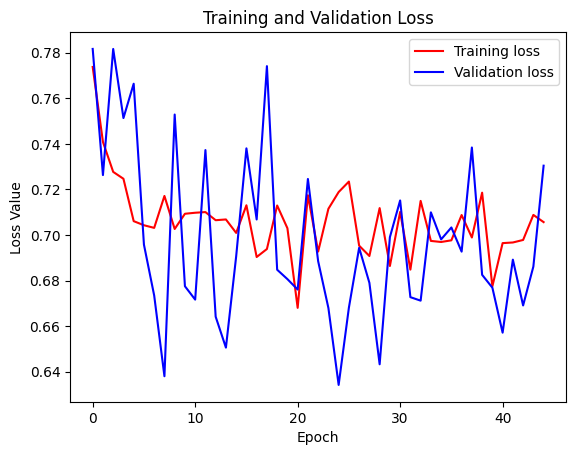

In [48]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

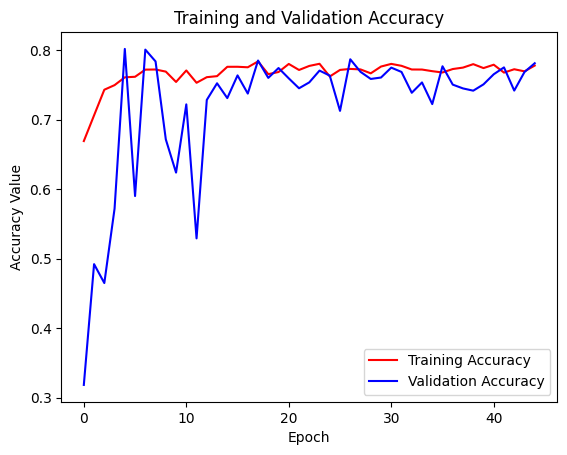

In [49]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()
plt.plot(history.epoch, accuracy, 'r', label='Training Accuracy')
plt.plot(history.epoch, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

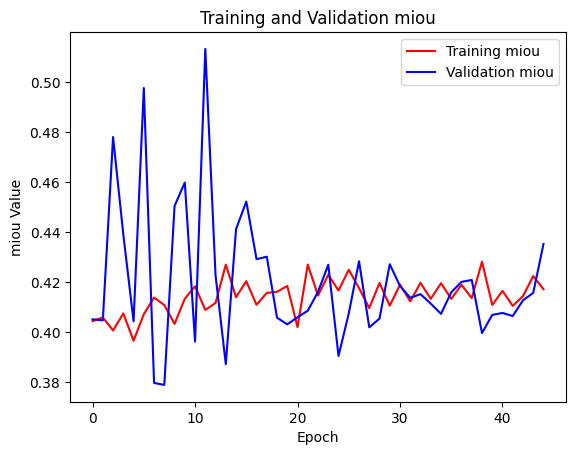

In [51]:
miou = history.history['mean_io_u']
val_miou = history.history['val_mean_io_u']

plt.figure()
plt.plot(history.epoch, miou, 'r', label='Training miou')
plt.plot(history.epoch, val_miou, 'b', label='Validation miou')
plt.title('Training and Validation miou')
plt.xlabel('Epoch')
plt.ylabel('miou Value')
plt.legend()
plt.show()

## Model Prediction

In [52]:
#!mkdir kaggle/working/aerialimage/test_input/input_data
!mkdir /content/aerialimage/test_input
!mkdir /content/aerialimage/test_input/input_data
!mkdir /content/aerialimage/test_patches
!mkdir /content/aerialimage/test_patches/images_patches

In [53]:
# move input images to the folder

# org_test_input = '/kaggle/input/aerialimagedataset/AerialImageDataset/test/images/'
# new_test_input = '/kaggle/working/aerialimage/test_input/input_data'


org_test_input = '/content/Colab Notebooks/AerialImageDataset/test/images'
new_test_input = '/content/aerialimage/test_input/input_data/'


input_img_paths = []

for dirname, _, filenames in os.walk(org_test_input):
    for filename in filenames:
        input_img_paths.append(os.path.join(dirname, filename))

input_img_paths = sorted(input_img_paths)

random.Random(23).shuffle(input_img_paths)
    
input_img_paths[0:2]

[]

In [54]:
# copy 10% input images to test folder!

for i, file in enumerate(input_img_paths):
    if i%10 == 0:
        shutil.copy(file, new_test_input)

In [55]:
# test_input_datagen = ImageDataGenerator(rescale=1./255)
test_target_datagen = ImageDataGenerator(rescale=1./255)
test_input_datagen = ImageDataGenerator()
# test_target_datagen = ImageDataGenerator()

In [56]:



# For test images patching!
overlap = 0  # Specify the desired overlap size, 0% for this case. no need overlap for test data!!

# Specify the absolute path to the "aerialimage" folder
absolute_path = '/content/aerialimage'

# Construct the absolute path to the "train/images" directory for reading
test_images_dir =  new_test_input

# Retrieve a list of files in the "train/images" directory
files = os.listdir(test_images_dir)

# Filter files based on criteria (e.g., file extension)
image_files = [file for file in sorted(files) if file.endswith('.tif')]

# Construct the absolute path to the "train_patches" directory for writing
#train_images_patches_dir = absolute_path + '/train_patches/images_patches/'
#train_gt_patches_dir = absolute_path + '/train_patches/gt_patches/'

# Construct the absolute path to the "test_patches" directory for writing
test_images_patches_dir = absolute_path + '/test_patches/images_patches/'

#patches_imgs = []

for image_file in image_files:
#    print(image_file)
    image_path = test_images_dir + image_file
#    print(image_path)
    image = cv2.imread(image_path)   #read image
#    print(image.shape, image.shape[:2])
    
    # image1 = Image.open(image_path)
    # plt.imshow(image1)
    # break

    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width), (0, 0)), mode='constant')
    patches = create_patches(padded_image, patch_size, overlap)
# #    patches = create_patches(image, patch_size, overlap)
# #    print(image_file)
# #    print(train_images_patches_dir)
    for i, patch in enumerate(patches):
        patch_name = f'{image_file[:-4]}_patch_{i+1}.tif'
        cv2.imwrite(test_images_patches_dir + patch_name, patch)

In [ ]:
# # use data augmentation pipeline and start loading validation data from folders
# #test_patch_input_datagen = ImageDataGenerator(rescale=1./255)
# test_patch_input_datagen = ImageDataGenerator()
# #test_patch_target_datagen = ImageDataGenerator(rescale=1./255)

# test_generator_input_patch = test_patch_input_datagen.flow_from_directory(
#     '/content/aerialimage/test_patches/',
#     target_size=TARGET_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode=None,
#     seed = seed

# )

# # test_generator_output_patch = test_patch_target_datagen.flow_from_directory(
# #     '/content/aerialimage/test_targetpatches/',
# #     target_size=TARGET_SIZE,
# #     batch_size=BATCH_SIZE,
# #     class_mode=None,
# #     color_mode="grayscale",
# #     seed = seed
# # )

# # test_patch_generator = zip(test_generator_input_patch, test_generator_output_patch)

Found 1800 images belonging to 1 classes.


In [57]:
# len(test_generator_input_patch), type(test_generator_input_patch)

In [58]:
test_images_patches_dir = absolute_path + '/test_patches/images_patches/'

# Retrieve a list of files in the "train/images" directory
files = os.listdir(test_images_patches_dir)

# Filter files based on criteria (e.g., file extension)
image_files = [file for file in sorted(files) if file.endswith('.tif')]

count = 0
for image_file in image_files:
    count += 1
#    print(image_file)
    image_path = test_images_patches_dir + image_file
    print(image_path)
    image = cv2.imread(image_path)   #read image
    print(image.shape, image.shape[:2])
    
    if count > 49:
        image1 = Image.open(image_path)
        plt.imshow(image1)
        break

#predicted_image = nopatch_model.predict(np.expand_dims(test_input[i], axis=0))[0]
#predicted_image = model.predict(np.expand_dims(test_generator_input_patch[0], axis=0))[0]

1/1 [==============================] - 0s 20ms/step
(512, 512, 1)


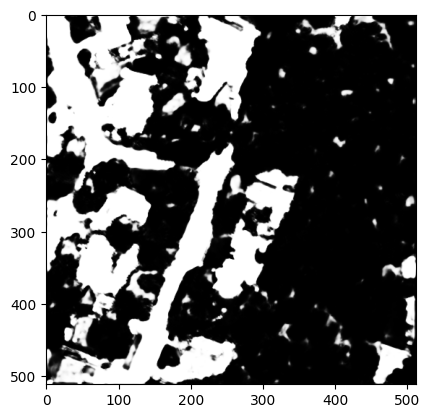

In [ ]:
predicted_image = model.predict(np.expand_dims(image, axis=0))[0]
print(predicted_image.shape)
plt.imshow(predicted_image, cmap = 'gray')

In [ ]:

# # Prediction Utilities

# def create_mask(pred_mask):
# #   '''
# #   Creates the segmentation mask by getting the channel with the highest probability. Remember that we
# #   have 3 channels in the output of the UNet. For each pixel, the predicition will be the channel with the
# #   highest probability.
# #   '''
#     pred_mask = tf.argmax(pred_mask, axis=-1)
#     pred_mask = pred_mask[..., tf.newaxis]
#     return pred_mask[0].numpy()

# def make_predictions(image, num=1):
# #   '''
# #   Feeds an image to a model and returns the predicted mask.
# #   '''

#     pred_mask = model.predict(image)
#     pred_mask = create_mask(pred_mask)

#     return pred_mask

In [ ]:
# # load the filename in the directory

# def read_file(directory):
#     blind_test = []
#     for dirname, _, filenames in os.walk(directory):
#         for filename in filenames:
#             blind_test.append(os.path.join(dirname, filename))
#     blind_test = sorted(blind_test)
#     return blind_test

# # build the dataset using list of filenames and target image size
# def build_dataset(dir_list, img_size):
#     num_imgs = len(dir_list)
#     test_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")

#     for i in range(len(dir_list)):
#         test_imgs[i] = img_to_array(load_img(dir_list[i], target_size=img_size))
#     return test_imgs
#  
# img_size = (512,512)
# directory_input = '/kaggle/working/aerialimage/val_input/input_data'
# directory_target = '/kaggle/working/aerialimage/val_target/target_data'


# val_input_dir = read_file(directory_input)
# val_target_dir = read_file(directory_target)


# val_input = build_dataset(val_input_dir, img_size)
# val_target = build_dataset(val_target_dir, img_size)


# print("Shape of val input data:", val_input.shape)
# print("Shape of val input target:", val_target.shape)


In [ ]:
# def display_data(test_imgs , target_imgs, num1, num2, model_load):
#     plt.figure(figsize=(100,100))  
#     s = num1
#     i = num2

#     count = 1

#     for k in range(s,i,1):
#         input_image = test_imgs[k]
#         target_image = target_imgs[k]

#         prediction = model_load.predict(np.expand_dims(input_image, 0))[0]
#         pred_threshold = prediction > 0.5
#         pred_threshold = pred_threshold * 255

#         plt.subplot(6,6,3*count-2)
#         plt.axis("off")
#         plt.imshow(array_to_img(input_image))

#         plt.subplot(6,6,3*count-1)
#         plt.axis("off")
#         plt.imshow(array_to_img(target_image), cmap="gray") 
#         plt.tight_layout()


#         plt.subplot(6,6,3*count)
#         plt.axis("off")
#         plt.imshow(pred_threshold, cmap="gray")

#         count += 1

#     plt.show()
#     plt.tight_layout()


In [ ]:
# def display(display_list,titles=[], display_string=None):
# #   '''displays a list of images/masks'''

#   plt.figure(figsize=(15, 15))

#     for i in range(len(display_list)):
#         plt.subplot(1, len(display_list), i+1)
#         plt.title(titles[i])
#         plt.xticks([])
#         plt.yticks([])
#         if display_string and i == 1:
#               plt.xlabel(display_string, fontsize=12)
#         img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
#         plt.imshow(img_arr)

#     plt.show()


In [ ]:
# def show_predictions(dataset=None, num=1):
#     if dataset:
#         for imagein dataset.take(num):
#             pred_mask = model.predict(image)
#             display([image[0], create_mask(pred_mask)])